# DIY document processing for RAG system

Docs used for this demonstration
* The [official rules of baseball](https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf)
* Federal National Mortgage Association ([Fannie Mae](https://www.fanniemae.com/))
* Federal Home Loan Mortgage Corporation ([Freddie Mac](https://www.freddiemac.com/))

> use LangChain and Google Cloud + LangChain integrations to orchestrate RAG pipeline

In [2]:
! cd .. && tree

.
├── README.md
├── notebooks
│   ├── 01_ingest_rag.ipynb
│   └── 02_grounded_rag.ipynb
├── requirements.txt
└── src
    ├── display_utils.py
    ├── docai_utils.py
    ├── gcs_loader.py
    └── vvs_utils.py

2 directories, 8 files


## pip & package

In [27]:
# tuples of (import name, install name, min_version)
# packages = [
#     ('google.cloud.documentai', 'google-cloud-documentai', '2.31.0'),
#     ('google.cloud.storage', 'google-cloud-storage'),
#     ('fitz', 'pymupdf'),
#     ('PIL', 'Pillow')
# ]

# import importlib
# install = False
# for package in packages:
#     if not importlib.util.find_spec(package[0]):
#         print(f'installing package {package[1]}')
#         install = True
#         !pip install {package[1]} -U -q --user
#     elif len(package) == 3:
#         if importlib.metadata.version(package[0]) < package[2]:
#             print(f'updating package {package[1]}')
#             install = True
#             !pip install {package[1]} -U -q --user

## imports

In [140]:
import vertexai
from google.cloud import storage
from google.cloud import documentai
from google.cloud import aiplatform
from google.cloud import discoveryengine
from typing import TYPE_CHECKING, Iterator, List, Optional, Sequence

import os
import re
import IPython.display
import io
import json
import base64
import requests
import concurrent.futures
import asyncio
import fitz #pymupdf
import PIL.Image

print(f"Vertex AI SDK version = {vertexai.__version__}")
print(f"Document AI API version = {documentai.__version__}")
print(f"Discovery Engine API version = {discoveryengine.__version__}")

# this repo
import sys
sys.path.append("..")
from src import display_utils, docai_utils, gcs_loader, vvs_utils

Vertex AI SDK version = 1.71.0
Document AI API version = 2.35.0
Discovery Engine API version = 0.11.14


## config

In [4]:
PREFIX="mortgage-ball"

In [51]:
PROJECT_ID = "hybrid-vertex"
REGION = "us-central1"
LOCATION = REGION.split('-')[0]
GCS_BUCKET_URI = f"gs://{PREFIX}-bucket"

vertexai.init(project=PROJECT_ID, location=REGION)
print(f"Vertex AI SDK initialized.")

# Cloud storage buckets
GCS_OUTPUT_PATH = f"{GCS_BUCKET_URI}"  # DocAI Layout Parser Output Path
GCS_BUCKET_NAME = GCS_BUCKET_URI.replace("gs://", "")

# Vertex AI Vector Search
VS_INDEX_NAME = f"{PREFIX}-v1-index"  # @param {type:"string"}
VS_INDEX_ENDPOINT_NAME = f"{VS_INDEX_NAME}-endpoint"  # @param {type:"string"}
VS_CONTENTS_DELTA_URI = f"{GCS_BUCKET_URI}/index/embeddings"
VS_DIMENSIONS = 768
VS_APPROX_NEIGHBORS = 150
VS_INDEX_UPDATE_METHOD = "STREAM_UPDATE"
VS_INDEX_SHARD_SIZE = "SHARD_SIZE_SMALL"
VS_LEAF_NODE_EMB_COUNT = 500
VS_LEAF_SEARCH_PERCENT = 80
VS_DISTANCE_MEASURE_TYPE = "DOT_PRODUCT_DISTANCE"
VS_MACHINE_TYPE = "e2-standard-16"
VS_MIN_REPLICAS = 1
VS_MAX_REPLICAS = 1
VS_DESCRIPTION = "Index for DIY RAG with Vertex AI APIs"  # @param {type:"string"}

# Models
EMBEDDINGS_MODEL_NAME = "text-embedding-004"
LLM_MODEL_NAME = "gemini-1.5-pro"

# DocumentAI Processor
DOCAI_LOCATION = "us"  # @param ["us", "eu"]
DOCAI_PROCESSOR_NAME = f"{PREFIX}-v1"  # @param {type:"string"}

print(f"GCS_BUCKET_URI         : {GCS_BUCKET_URI}")
print(f"VS_INDEX_NAME          : {VS_INDEX_NAME}")
print(f"DOCAI_PROCESSOR_NAME   : {DOCAI_PROCESSOR_NAME}")
print(f"VS_INDEX_ENDPOINT_NAME : {VS_INDEX_ENDPOINT_NAME}")

Vertex AI SDK initialized.
GCS_BUCKET_URI         : gs://mortgage-ball-bucket
VS_INDEX_NAME          : mortgage-ball-v1-index
DOCAI_PROCESSOR_NAME   : mortgage-ball-v1
VS_INDEX_ENDPOINT_NAME : mortgage-ball-v1-index-endpoint


### Enable / Disable flags

In [6]:
# Enable/disable flags
# flag to create Google Cloud resources configured above
# refer to the notes before this cell
CREATE_RESOURCES = True  # @param {type:"boolean"}
# flag to run data ingestion
RUN_INGESTION = True  # @param {type:"boolean"}

### helper functions

In [7]:
# @title Utility methods for adding index to Vertex AI Vector Search
def get_batches(items: List, n: int = 1000) -> List[List]:
    n = max(1, n)
    return [items[i : i + n] for i in range(0, len(items), n)]


def add_data(vector_store, chunks) -> None:
    if RUN_INGESTION:
        batch_size = 1000
        texts = get_batches([chunk.page_content for chunk in chunks], n=batch_size)
        metadatas = get_batches([chunk.metadata for chunk in chunks], n=batch_size)

        for i, (b_texts, b_metadatas) in enumerate(zip(texts, metadatas)):
            print(f"Adding {len(b_texts)} data points to index")
            is_complete_overwrite = bool(i == 0)
            vector_store.add_texts(
                texts=b_texts,
                metadatas=b_metadatas,
                is_complete_overwrite=is_complete_overwrite,
            )
    else:
        print("Skipping ingestion. Enable `RUN_INGESTION` flag")

# Create or initialize resources

## create Cloud Storage bucket

In [8]:
if CREATE_RESOURCES:
    print("Creating new resources.")
else:
    print("Resource creation is skipped.")

bucket = vvs_utils.create_bucket(
    bucket_name = GCS_BUCKET_NAME, 
    create_resources=CREATE_RESOURCES
)

Creating new resources.
Bucket mortgage-ball-bucket created


## Vector Search index

In [10]:
# Create vector search index if not exists else return index resource name
vs_index = vvs_utils.create_index(
    project_id=PROJECT_ID,
    region=REGION,
    sync_job=True,
    create_resources=CREATE_RESOURCES, # bool, 
    vs_index_name=VS_INDEX_NAME, # str,
    vs_dimensions=VS_DIMENSIONS, # int,
    vs_approx_neghbors=VS_APPROX_NEIGHBORS, # int,
    distance_measure_type=VS_DISTANCE_MEASURE_TYPE, # str,
    vs_leaf_node_emb_count=VS_LEAF_NODE_EMB_COUNT, # int,
    vs_leaf_search_percent=VS_LEAF_SEARCH_PERCENT, # int,
    vs_description=VS_DESCRIPTION, # str,
    vs_index_shard_size=VS_INDEX_SHARD_SIZE, # str,
    vs_index_update_method=VS_INDEX_UPDATE_METHOD, # str,
)
vs_index.to_dict()

Creating Vector Search index mortgage-ball-v1-index ...
Creating MatchingEngineIndex
Create MatchingEngineIndex backing LRO: projects/934903580331/locations/us-central1/indexes/1202439110275366912/operations/5957923279472689152
MatchingEngineIndex created. Resource name: projects/934903580331/locations/us-central1/indexes/1202439110275366912
To use this MatchingEngineIndex in another session:
index = aiplatform.MatchingEngineIndex('projects/934903580331/locations/us-central1/indexes/1202439110275366912')
Vector Search index mortgage-ball-v1-index created with resource name projects/934903580331/locations/us-central1/indexes/1202439110275366912


{'name': 'projects/934903580331/locations/us-central1/indexes/1202439110275366912',
 'displayName': 'mortgage-ball-v1-index',
 'description': 'Index for DIY RAG with Vertex AI APIs',
 'metadataSchemaUri': 'gs://google-cloud-aiplatform/schema/matchingengine/metadata/nearest_neighbor_search_1.0.0.yaml',
 'metadata': {'config': {'dimensions': 768.0,
   'approximateNeighborsCount': 150.0,
   'distanceMeasureType': 'DOT_PRODUCT_DISTANCE',
   'algorithmConfig': {'treeAhConfig': {'leafNodeEmbeddingCount': '500',
     'leafNodesToSearchPercent': 80.0}},
   'shardSize': 'SHARD_SIZE_SMALL'}},
 'etag': 'AMEw9yOgBDmZoBM_GiUSJcfGw8iveOjvVS_lm8t8t1UE1Wp-7SS3iUi0D_XqBo080Oc=',
 'createTime': '2024-11-06T05:03:23.500281Z',
 'updateTime': '2024-11-06T05:03:50.196807Z',
 'indexStats': {'shardsCount': 1},
 'indexUpdateMethod': 'STREAM_UPDATE',
 'encryptionSpec': {}}

## Vector Search index endpoint

In [15]:
# Create vector search index endpoint if not exists else return index endpoint resource name
vs_endpoint = vvs_utils.create_index_endpoint(
    project_id=PROJECT_ID,
    region=REGION,
    sync_job=True,
    vs_description=VS_DESCRIPTION,
    create_resources=CREATE_RESOURCES,
    vs_index_endpoint_name=VS_INDEX_ENDPOINT_NAME,
)

Creating Vector Search index endpoint mortgage-ball-v1-index-endpoint ...
Creating MatchingEngineIndexEndpoint
Create MatchingEngineIndexEndpoint backing LRO: projects/934903580331/locations/us-central1/indexEndpoints/3307168248629297152/operations/216678179505438720
MatchingEngineIndexEndpoint created. Resource name: projects/934903580331/locations/us-central1/indexEndpoints/3307168248629297152
To use this MatchingEngineIndexEndpoint in another session:
index_endpoint = aiplatform.MatchingEngineIndexEndpoint('projects/934903580331/locations/us-central1/indexEndpoints/3307168248629297152')
Vector Search index endpoint mortgage-ball-v1-index-endpoint created with resource name projects/934903580331/locations/us-central1/indexEndpoints/3307168248629297152


In [17]:
vs_endpoint.to_dict()

{'name': 'projects/934903580331/locations/us-central1/indexEndpoints/3307168248629297152',
 'displayName': 'mortgage-ball-v1-index-endpoint',
 'description': 'Index for DIY RAG with Vertex AI APIs',
 'deployedIndexes': [{'id': 'mortgage_ball_v1_index_c56d551518b5',
   'index': 'projects/934903580331/locations/us-central1/indexes/1202439110275366912',
   'displayName': 'mortgage-ball-v1-index',
   'createTime': '2024-11-06T05:06:52.996253Z',
   'indexSyncTime': '2024-11-06T05:32:33.342806Z',
   'deploymentGroup': 'default',
   'dedicatedResources': {'machineSpec': {'machineType': 'e2-standard-16'},
    'minReplicaCount': 1,
    'maxReplicaCount': 1}}],
 'etag': 'AMEw9yMe3E90G_fUJVjbuYYT5LJl3JBwKzaQ7E4q-ArY2R-R2tcgNXqosIeW0epOPLvg',
 'createTime': '2024-11-06T05:05:59.137518Z',
 'updateTime': '2024-11-06T05:05:59.715595Z',
 'publicEndpointDomainName': '1694631553.us-central1-934903580331.vdb.vertexai.goog',
 'encryptionSpec': {}}

## Deploy Vector Search index to endpoint

In [16]:
# Deploy index to the index endpoint
vvs_utils.deploy_index(
    index=vs_index, 
    endpoint=vs_endpoint,
    create_resources=CREATE_RESOURCES,
    vs_index_name=VS_INDEX_NAME,
    vs_machine_type=VS_MACHINE_TYPE,
    vs_min_replicas=VS_MIN_REPLICAS,
    vs_max_replicas=VS_MAX_REPLICAS,
)

Deploying Vector Search index mortgage-ball-v1-index at endpoint mortgage-ball-v1-index-endpoint ...
Deploying index MatchingEngineIndexEndpoint index_endpoint: projects/934903580331/locations/us-central1/indexEndpoints/3307168248629297152
Deploy index MatchingEngineIndexEndpoint index_endpoint backing LRO: projects/934903580331/locations/us-central1/indexEndpoints/3307168248629297152/operations/7187405977744834560
MatchingEngineIndexEndpoint index_endpoint Deployed index. Resource name: projects/934903580331/locations/us-central1/indexEndpoints/3307168248629297152
Vector Search index mortgage-ball-v1-index is deployed at endpoint mortgage-ball-v1-index-endpoint


resource name: projects/934903580331/locations/us-central1/indexEndpoints/3307168248629297152

### Inspect VVS

In [138]:
vs_index.to_dict() #['indexStats']

{'name': 'projects/934903580331/locations/us-central1/indexes/1202439110275366912',
 'displayName': 'mortgage-ball-v1-index',
 'description': 'Index for DIY RAG with Vertex AI APIs',
 'metadataSchemaUri': 'gs://google-cloud-aiplatform/schema/matchingengine/metadata/nearest_neighbor_search_1.0.0.yaml',
 'metadata': {'config': {'dimensions': 768.0,
   'approximateNeighborsCount': 150.0,
   'distanceMeasureType': 'DOT_PRODUCT_DISTANCE',
   'algorithmConfig': {'treeAhConfig': {'leafNodeEmbeddingCount': '500',
     'leafNodesToSearchPercent': 80.0}},
   'shardSize': 'SHARD_SIZE_SMALL'}},
 'etag': 'AMEw9yOgBDmZoBM_GiUSJcfGw8iveOjvVS_lm8t8t1UE1Wp-7SS3iUi0D_XqBo080Oc=',
 'createTime': '2024-11-06T05:03:23.500281Z',
 'updateTime': '2024-11-06T05:03:50.196807Z',
 'indexStats': {'shardsCount': 1},
 'indexUpdateMethod': 'STREAM_UPDATE',
 'encryptionSpec': {}}

## Create DocAI Layout processor

In [22]:
# Create Document Layout Processor
docai_processor = vvs_utils.create_docai_processor(
    project_id=PROJECT_ID,
    region=REGION, # str,
    create_resources=CREATE_RESOURCES,
    docai_location=DOCAI_LOCATION,
    processor_display_name=DOCAI_PROCESSOR_NAME,
    processor_type="LAYOUT_PARSER_PROCESSOR",
    processor_version="pretrained-layout-parser-v1.0-2024-06-03"
)
PROCESSOR_NAME = docai_processor.name  # DocAI Layout Parser Processor Name

print(f"PROCESSOR_NAME: {PROCESSOR_NAME}")

Creating Document AI processor mortgage-ball-v1 of type LAYOUT_PARSER_PROCESSOR ...
Document AI processor mortgage-ball-v1 of type LAYOUT_PARSER_PROCESSOR is created.
PROCESSOR_NAME: projects/934903580331/locations/us/processors/215ad0e7fce70f3e


In [52]:
# # document AI client
docai_client = documentai.DocumentProcessorServiceClient(
    client_options = dict(api_endpoint = f"{LOCATION}-documentai.googleapis.com")
)
docai_async_client = documentai.DocumentProcessorServiceAsyncClient(
    client_options = dict(api_endpoint = f"{LOCATION}-documentai.googleapis.com")
)

# Content processing and annotation - chunking

> *This steps reads documents from Cloud Storage bucket, parses them using Document AI layout processor, and extracts chunks from the parsed document. Later these chunks will be generate emebeddings using Vertex AI Embeddings API and add them to the Vertex AI Vector Search index.*

**steps**
* ingest documents from Cloud Storage bucket to [Vertex AI Vector Search](https://cloud.google.com/vertex-ai/docs/vector-search/overview) (VVS)
* use DocAI to parse documents and convert raw text to chunks


see [here](https://cloud.google.com/generative-ai-app-builder/docs/prepare-data#storage-unstructured) are some sample public datasets available in GCS for usage.

## Step 1. Process Documents

see guides here:
* [Large Document Parsing](https://github.com/statmike/vertex-ai-mlops/blob/main/Applied%20GenAI/Chunking/Large%20Document%20Processing%20-%20Document%20AI%20Layout%20Parser.ipynb) - for mortgage pdfs
* [Process Documents with DocAI Layout Parser](https://github.com/statmike/vertex-ai-mlops/blob/main/Applied%20GenAI/Chunking/Process%20Documents%20-%20Document%20AI%20Layout%20Parser.ipynb)

### 1.1 Load MLB rules

> see [example](https://github.com/statmike/vertex-ai-mlops/blob/main/Applied%20GenAI/Chunking/Process%20Documents%20-%20Document%20AI%20Layout%20Parser.ipynb)

In [43]:
EXPERIMENT="mlb"
SERIES = 'diyrag-v1'
REGION = 'us-central1'
LOCATION = REGION.split('-')[0]
mlb_rules_pdf = "https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf"

# gcs client: assumes bucket already exists
gcs = storage.Client(project = PROJECT_ID)
bucket = gcs.bucket(GCS_BUCKET_NAME)

print(f"EXPERIMENT    = {EXPERIMENT}")
print(f"SERIES        = {SERIES}")
print(f"REGION        = {REGION}")
print(f"PREFIX        = {PREFIX}")
print(f"LOCATION      = {LOCATION}")
print(f"bucket        = {bucket}")
print(f"mlb_rules_pdf = {mlb_rules_pdf}")

EXPERIMENT    = mlb
SERIES        = diyrag-v1
REGION        = us-central1
LOCATION      = us
bucket        = <Bucket: mortgage-ball-bucket>
mlb_rules_pdf = https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf


In [44]:
response = requests.get(mlb_rules_pdf).content
document = fitz.open(stream = response, filetype = "pdf")

document.page_count

192

#### Get Text From Pages

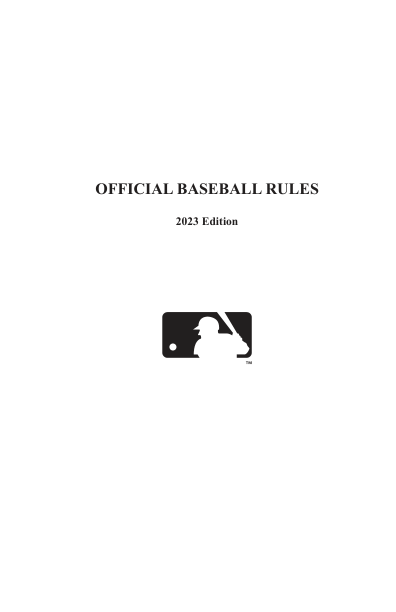

In [30]:
# view pages

def get_image(page):
    pix = page.get_pixmap()
    image = PIL.Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
    return image
page_images = [get_image(page) for page in document]
    
page_images[0]

In [31]:
pages = [page.get_text() for page in document]
pages[0]

'OFFICIAL BASEBALL RULES\n2023 Edition\n'

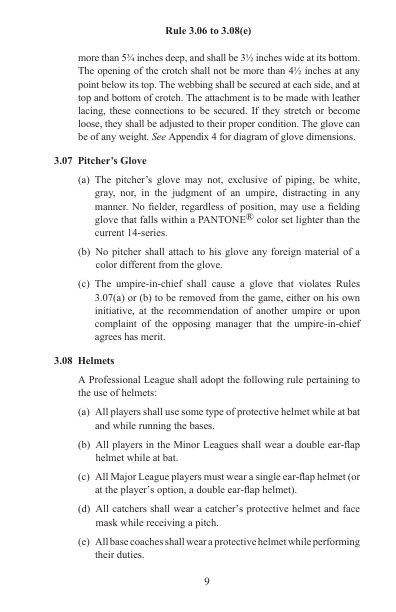

In [144]:
page_images[20]

In [145]:
pages[20]

'9\n Rule 3.06 to 3.08(e)\nmore than 5¾ inches deep, and shall be 3½ inches wide at its bottom. \nThe opening of the crotch shall not be more than 4½ inches at any \npoint below its top. The webbing shall be secured at each side, and at \ntop and bottom of crotch. The attachment is to be made with leather \nlacing, these connections to be secured. If they stretch or become \nloose, they shall be adjusted to their proper condition. The glove can \nbe of any weight. See Appendix 4 for diagram of glove dimensions.\n3.07\u2002 Pitcher’s Glove\n(a)\u2002 \x07The pitcher’s glove may not, exclusive of piping, be white, \ngray, nor, in the judgment of an umpire, distracting in any \nmanner. No fielder, regardless of position, may use a fielding \nglove that falls within a PANTONE® color set lighter than the \ncurrent 14-series.\n(b)\u2002 \x07No pitcher shall attach to his glove any foreign material of a \ncolor different from the glove.\n(c)\u2002 \x07The umpire-in-chief shall cause a glove t

#### Create small PDF with first 5 pages

In [32]:
small_document = fitz.open()
small_document.insert_pdf(document, from_page=0, to_page=4)
small_document.page_count

5

**Documents As Byte Strings**

In [33]:
buffer = io.BytesIO()
document.save(buffer)
document_bytes = base64.b64encode(buffer.getvalue()).decode('utf-8')

buffer = io.BytesIO()
small_document.save(buffer)
small_document_bytes = base64.b64encode(buffer.getvalue()).decode('utf-8')

**Documents as local files**

In [36]:
LOCAL_DIR = f"files/{EXPERIMENT}"

if not os.path.exists(LOCAL_DIR):
    os.makedirs(LOCAL_DIR)

In [38]:
document.save(f"{LOCAL_DIR}/document.pdf")
small_document.save(f"{LOCAL_DIR}/small_document.pdf")

os.listdir(LOCAL_DIR)

['small_document.pdf', 'document.pdf']

#### Upload documents to GCS objects

In [49]:
blob = bucket.blob(f'{PREFIX}/{EXPERIMENT}/files/document.pdf')
blob.upload_from_string(base64.b64decode(document_bytes), content_type = 'application/pdf')

blob = bucket.blob(f'{PREFIX}/{EXPERIMENT}/files/small_document.pdf')
blob.upload_from_string(base64.b64decode(small_document_bytes), content_type = 'application/pdf')

list(bucket.list_blobs(prefix = f'{PREFIX}/{EXPERIMENT}/files'))

[<Blob: mortgage-ball-bucket, mortgage-ball/mlb/files/document.pdf, 1730872602822592>,
 <Blob: mortgage-ball-bucket, mortgage-ball/mlb/files/small_document.pdf, 1730872602958306>]

#### Online processing...

##### Inline Document

References:
* [documentai.ProcessRequest()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.ProcessRequest)
* inline_document = [documentai.Document()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.Document)
* process_options = [documentai.ProcessOptions()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.ProcessOptions)
* layout_config = [documentai.ProcessOptions.LayoutConfig()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.ProcessOptions.LayoutConfig)

In [ ]:
PARSER_DISPLAY_NAME = 'my_layout_processor'
PARSER_TYPE = 'LAYOUT_PARSER_PROCESSOR'
PARSER_VERSION = 'pretrained-layout-parser-v1.0-2024-06-03'

# for p in docai_client.list_processors(parent = f'projects/{PROJECT_ID}/locations/{LOCATION}'):
#     if p.display_name == PARSER_DISPLAY_NAME:
#         parser = p
# try:
#     print('Retrieved existing parser: ', parser.name)
# except Exception:
#     parser = docai_client.create_processor(
#         parent = f'projects/{PROJECT_ID}/locations/{LOCATION}',
#         processor = dict(display_name = PARSER_DISPLAY_NAME, type_ = PARSER_TYPE, default_processor_version = PARSER_VERSION)
#     )
#     print('Created New Parser: ', parser.name)

In [54]:
# docai_processor
online_inline_response = docai_client.process_document(
    request = documentai.ProcessRequest(
        name = docai_processor.name,
        inline_document = documentai.Document(
            content = small_document_bytes,
            mime_type = 'application/pdf'
        ),
        process_options = documentai.ProcessOptions(
            from_start = 5,
            layout_config = documentai.ProcessOptions.LayoutConfig(
                chunking_config = documentai.ProcessOptions.LayoutConfig.ChunkingConfig(
                    chunk_size = 100,
                    include_ancestor_headings = True,
                )
            )
        ),
    )
)

**Review response for:**`document_layout.blocks` & `chunked_document.chunks`

In [57]:
# online_inline_response.document.document_layout.blocks[0].text_block.text

In [58]:
# len(online_inline_response.document.chunked_document.chunks)

In [59]:
# online_inline_response.document.chunked_document.chunks[0]

##### Raw Document

In [60]:
online_raw_response = docai_client.process_document(
    request = documentai.ProcessRequest(
        name = docai_processor.name,
        raw_document = documentai.RawDocument(
            content = small_document_bytes,
            mime_type = 'application/pdf'
        ),
        process_options = documentai.ProcessOptions(
            from_start = 5,
            layout_config = documentai.ProcessOptions.LayoutConfig(
                chunking_config = documentai.ProcessOptions.LayoutConfig.ChunkingConfig(
                    chunk_size = 100,
                    include_ancestor_headings = True,
                )
            )
        )
    )
)

**Review response for:**`document_layout.blocks` & `chunked_document.chunks`

In [61]:
# online_raw_response.document.document_layout.blocks[0].text_block.text

In [62]:
# len(online_raw_response.document.chunked_document.chunks)

In [63]:
# online_raw_response.document.chunked_document.chunks[0]

##### GCS Document

In [65]:
online_gcs_response = docai_client.process_document(
    request = documentai.ProcessRequest(
        name = docai_processor.name,
        gcs_document = documentai.GcsDocument(
            gcs_uri = f'gs://{bucket.name}/{PREFIX}/{EXPERIMENT}/files/small_document.pdf',
            mime_type = 'application/pdf'
        ),
        process_options = documentai.ProcessOptions(
            from_start = 5,
            layout_config = documentai.ProcessOptions.LayoutConfig(
                chunking_config = documentai.ProcessOptions.LayoutConfig.ChunkingConfig(
                    chunk_size = 100,
                    include_ancestor_headings = True,
                )
            )
        )
    )
)
# gs://mortgage-ball-bucket/mortgage-ball/mlb/files/small_document.pdf
# gs://mortgage-ball-bucket/mlb/files/small_document.pdf

**Review response for:**`document_layout.blocks` & `chunked_document.chunks`

In [66]:
# online_gcs_response.document.document_layout.blocks[0].text_block.text

In [67]:
# len(online_gcs_response.document.chunked_document.chunks)

In [68]:
# online_gcs_response.document.chunked_document.chunks[0]

#### Batch Processing: Multiple Documents and/or Larger Documents

In [69]:
batch_job = docai_client.batch_process_documents(
    request = documentai.BatchProcessRequest(
        name = docai_processor.name,
        input_documents = documentai.BatchDocumentsInputConfig(
            gcs_prefix = documentai.GcsPrefix(
                gcs_uri_prefix = f'gs://{bucket.name}/{PREFIX}/{EXPERIMENT}/files/'
            )
        ),
        document_output_config = documentai.DocumentOutputConfig(
            gcs_output_config = documentai.DocumentOutputConfig.GcsOutputConfig(
                gcs_uri = f'gs://{bucket.name}/{PREFIX}/{EXPERIMENT}/parsing'
            )
        ),
        process_options = documentai.ProcessOptions(
            layout_config = documentai.ProcessOptions.LayoutConfig(
                chunking_config = documentai.ProcessOptions.LayoutConfig.ChunkingConfig(
                    chunk_size = 100,
                    include_ancestor_headings = True,
                )
            )
        )
    )
)

print(f'Waiting on batch job to complete: {batch_job.operation.name}')
batch_job.result()

print(documentai.BatchProcessMetadata(batch_job.metadata).state)

Waiting on batch job to complete: projects/934903580331/locations/us/operations/16614205516256981526
State.SUCCEEDED


In [70]:
# Retrieve Document Parsing Results

batch_responses = []

for process in documentai.BatchProcessMetadata(batch_job.metadata).individual_process_statuses:
    matches = re.match(r"gs://(.*?)/(.*)", process.output_gcs_destination)
    output_bucket, output_prefix = matches.groups()
    output_blobs = bucket.list_blobs(prefix = output_prefix)
    for blob in output_blobs:
        response = documentai.Document.from_json(blob.download_as_bytes(), ignore_unknown_fields = True)
        batch_responses.append((blob.name.split('/')[-1], response))
        
        
len(batch_responses)

2

In [71]:
# batch_responses[0][0], batch_responses[1][0]

In [72]:
# batch_responses[0][1].chunked_document.chunks[0]

In [73]:
# batch_responses[1][1].chunked_document.chunks[0]

#### Online Async Processing: 

> Multiple Parallel Requests For Different Pages

**Determine The Number of Document Segments**

A single request for online processing can handle 15 pages. Determine the number of 15 page segments with a little math:

* how many full 15 page segments: document.page_count // 15
* is there a partial segment at the end?: 1 * min(1, document.page_count % 15)
* add these together

In [74]:
document.page_count

192

In [75]:
num_segments = document.page_count // 15 + 1 * min(1, document.page_count % 15)
num_segments

13

In [76]:
page_segments = []

for segment in range(num_segments):
    page_segments.append(
        [i+1 for i in range(15*segment, min(document.page_count, 15*(segment + 1)))]
    )

print(
    'Number of segments: ', len(page_segments),
    '\nPages in first segment: ', page_segments[0],
    '\nPages in last segment: ', page_segments[-1]
)

Number of segments:  13 
Pages in first segment:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] 
Pages in last segment:  [181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192]


##### Async Requests For Each Segment:

In [78]:
online_async_responses = await asyncio.gather(
    *[
        docai_async_client.process_document(
            request = documentai.ProcessRequest(
                name = docai_processor.name,
                inline_document = documentai.Document(
                    content = document_bytes,
                    mime_type = 'application/pdf'
                ),
                process_options = documentai.ProcessOptions(
                    individual_page_selector = documentai.ProcessOptions.IndividualPageSelector(
                        pages = segment
                    ),
                    layout_config = documentai.ProcessOptions.LayoutConfig(
                        chunking_config = documentai.ProcessOptions.LayoutConfig.ChunkingConfig(
                            chunk_size = 100,
                            include_ancestor_headings = True,
                        )
                    )
                ),
            )
        ) for segment in page_segments
    ]
)

How many chunks were created for each segment?

> note: (to confirm) It appears the full document is being processe rather than the page range even though it exceed the 15 page max

In [79]:
for response in online_async_responses:
    print(len(response.document.chunked_document.chunks))

866
866
866
866
866
866
866
866
866
866
866
866
866


##### Examine A Chunk

In [81]:
batch_responses[0][0]

'document-0.json'

In [82]:
response = batch_responses[0][1]
type(response)

google.cloud.documentai_v1.types.document.Document

In [83]:
response.chunked_document.chunks[1]

chunk_id: "c2"
content: "# OFFICIAL BASEBALL RULES\n\n## Official Baseball Rules 2023 Edition\n\n### JOINT COMPETITION COMMITTEE\n\n|-|-|-|\n| Bill DeWitt | Whit Merrifield | Austin Slater |\n| Jack Flaherty | Bill Miller | John Stanton, Chair |\n| Tyler Glasnow | Dick Monfort | Tom Werner |\n| Greg Johnson | Mark Shapiro |  |\n\nCommittee Secretary Paul V. Mifsud, Jr. Copyright © 2023 by the Office of the Commissioner of Baseball"
page_span {
  page_start: 2
  page_end: 3
}

In [84]:
response.chunked_document.chunks[1].chunk_id

'c2'

In [85]:
response.chunked_document.chunks[1].content

'# OFFICIAL BASEBALL RULES\n\n## Official Baseball Rules 2023 Edition\n\n### JOINT COMPETITION COMMITTEE\n\n|-|-|-|\n| Bill DeWitt | Whit Merrifield | Austin Slater |\n| Jack Flaherty | Bill Miller | John Stanton, Chair |\n| Tyler Glasnow | Dick Monfort | Tom Werner |\n| Greg Johnson | Mark Shapiro |  |\n\nCommittee Secretary Paul V. Mifsud, Jr. Copyright © 2023 by the Office of the Commissioner of Baseball'

In [86]:
print(response.chunked_document.chunks[1].content)

# OFFICIAL BASEBALL RULES

## Official Baseball Rules 2023 Edition

### JOINT COMPETITION COMMITTEE

|-|-|-|
| Bill DeWitt | Whit Merrifield | Austin Slater |
| Jack Flaherty | Bill Miller | John Stanton, Chair |
| Tyler Glasnow | Dick Monfort | Tom Werner |
| Greg Johnson | Mark Shapiro |  |

Committee Secretary Paul V. Mifsud, Jr. Copyright © 2023 by the Office of the Commissioner of Baseball


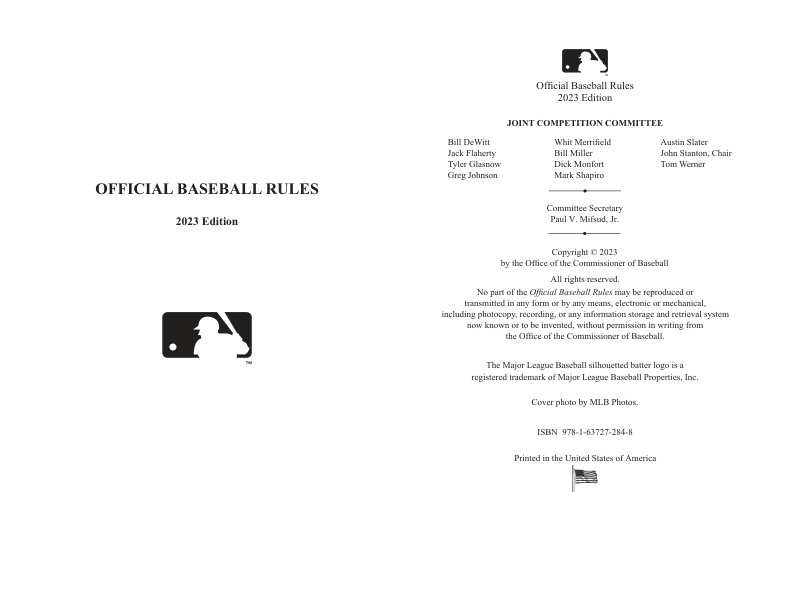

In [87]:
show = PIL.Image.new('RGB', (page_images[0].size[0]+page_images[1].size[0], page_images[0].size[1]))
show.paste(page_images[0], (0,0))
show.paste(page_images[1], (page_images[0].size[0], 0))
show

#### Process and Store Chunks

* convert chunks to a Python dictionary
* store the chunks in a JSONL file in this repository

In [88]:
chunks = documentai.Document.to_dict(response, use_integers_for_enums = False)['chunked_document']['chunks']

type(chunks[0])

dict

In [89]:
chunks[0]

{'chunk_id': 'c1',
 'content': '# OFFICIAL BASEBALL RULES\n\n2023 Edition TM TM',
 'page_span': {'page_start': 1, 'page_end': 7},
 'page_footers': [{'text': 'V1',
   'page_span': {'page_start': 6, 'page_end': 6}},
  {'text': 'vii', 'page_span': {'page_start': 7, 'page_end': 7}}],
 'source_block_ids': [],
 'page_headers': []}

In [90]:
len(chunks)

866

Create A local file of JSONL from the list of chunk dictionaries:

In [91]:
with open(f'{LOCAL_DIR}/document-chunks.jsonl', 'w') as f:
    for chunk in chunks:
        f.write(json.dumps(chunk)+ '\n')

In [93]:
os.listdir(LOCAL_DIR)

['document-chunks.jsonl', 'small_document.pdf', 'document.pdf']

#### Review The Document.DocumentLayout Parts

In [125]:
#response.document_layout.blocks[0]
response.document_layout.blocks[0].block_id

'1'

In [126]:
response.document_layout.blocks[0].page_span

page_start: 1
page_end: 1

In [127]:
response.document_layout.blocks[0].text_block.text

'(b) How to obtain a short sale property value and minimum net proceeds'

In [128]:
response.document_layout.blocks[0].text_block.type_

'heading-1'

In [129]:
# examine blocks
blocks = documentai.Document.to_dict(response, use_integers_for_enums = False)['document_layout']['blocks']

**Blocks are structured representations of sections of the document that the parser detected based on heading levels and titles.**

In [130]:
blocks[0]['page_span']
# blocks[1]['page_span']
# blocks[2]['page_span']
# blocks[3]['page_span']
# blocks[-2]['page_span']
# blocks[-1]['page_span']

{'page_start': 1, 'page_end': 1}

#### Sumarize a block: This function will summarize a block and print out the details:

In [131]:
def summarize_blocks(blocks):
    """Provides a descriptive summary of a list of dictionaries with nested block structures.

    Args:
        blocks: A list of dictionaries representing content blocks.

    Returns:
        A string with a summary of the block structure.
    """
    summary = ""
    for block in blocks:
        for key, value in block.items():
            if key == "text_block":
                text_type = value.get('type_', 'unknown type')
                summary += f"- Text block ({text_type}): {value.get('text', '')[:50]}...\n"
                if value.get("blocks"):
                    summary += "  Nested blocks:\n"
                    summary += summarize_blocks(value["blocks"])  # Recursive call
            elif key == "table_block":
                summary += "- Table block\n"
                if value.get("header_rows"):
                    summary += f"  Header rows: {len(value['header_rows'])}\n"
                if value.get("body_rows"):
                    summary += f"  Body rows: {len(value['body_rows'])}\n"
                if value.get("caption"):
                    summary += f"  Caption: {value['caption']}\n"
            elif key == "list_block":
                summary += "- List block\n"
                if value.get("list_entries"):
                    summary += f"  List entries: {len(value['list_entries'])}\n"

    return summary

# Example usage with your provided data
summary = summarize_blocks(blocks[0:1])
print(summary)

- Text block (heading-1): (b) How to obtain a short sale property value and ...
  Nested blocks:
- Text block (paragraph): With the exception of Mortgages secured by propert...
- Text block (paragraph): The Servicer must advise the Borrower that the per...
- Text block (paragraph): An “estimated market value” of the Mortgaged Premi...
- Text block (paragraph): Refer to Chapter 2404 for terms and requirements f...



#### Process and Store Blocks

In [132]:
with open(f'{LOCAL_DIR}/document-blocks.jsonl', 'w') as f:
    for block in blocks:
        f.write(json.dumps(block)+ '\n')
        
os.listdir(LOCAL_DIR)

['document-chunks.jsonl',
 'small_document.pdf',
 'document-blocks.jsonl',
 'document.pdf']

## 1.2 Load mortgage guides

> see [example](https://github.com/statmike/vertex-ai-mlops/blob/main/Applied%20GenAI/Chunking/Large%20Document%20Processing%20-%20Document%20AI%20Layout%20Parser.ipynb)

In [106]:
import os, time, io, re, json

import requests
import fitz #pymupdf
import PIL.Image

EXPERIMENT_L="lending"
LOCAL_LENDER_DIR = f"files/{EXPERIMENT_L}"

freddie_url = "https://guide.freddiemac.com/ci/okcsFattach/get/1002095_2"
fannie_url = "https://singlefamily.fanniemae.com/media/39861/display"

In [ ]:
if not os.path.exists(LOCAL_LENDER_DIR):
    os.makedirs(LOCAL_LENDER_DIR)

In [95]:
freddie_retrieve = requests.get(freddie_url).content
fannie_retrieve = requests.get(fannie_url).content

freddie_doc = fitz.open(stream = freddie_retrieve, filetype = 'pdf')
fannie_doc = fitz.open(stream = fannie_retrieve, filetype = 'pdf')

freddie_doc.page_count, fannie_doc.page_count

(2641, 1180)

### Split Documents

> The layout parser has a maximum page size per document of 500 pages and can handle 5,000 files. Here the pdf is split into parts of no more 
than 400 pages.

see [Layout Parser Limits](https://cloud.google.com/document-ai/docs/layout-parse-chunk#limitations)

In [96]:
def doc_parts(doc):
    start_page = 0
    max_pages = 400
    n_pages = doc.page_count
    
    doc_list = []
    while start_page < n_pages:
        end_page = min(start_page + max_pages - 1, n_pages)
        new_doc = fitz.open()
        new_doc.insert_pdf(doc, from_page = start_page, to_page = end_page)
        doc_list.append(new_doc)
        start_page = end_page + 1
    
    PRINT_STRINGS_1 = f"document has {n_pages} pages and has been split into"
    PRINT_STRINGS_2 = f"parts with page counts: {[p.page_count for p in doc_list]}"
    
    print(f"{PRINT_STRINGS_1} {PRINT_STRINGS_2}")
    # print(f"document has {n_pages} pages and has been split into parts with page counts: {[p.page_count for p in doc_list]}")
    
    return doc_list

In [97]:
freddie_parts = doc_parts(freddie_doc)

document has 2641 pages and has been split into parts with page counts: [400, 400, 400, 400, 400, 400, 241]


In [98]:
fannie_parts = doc_parts(fannie_doc)

document has 1180 pages and has been split into parts with page counts: [400, 400, 380]


### Documents as GCS Files

In [99]:
def doc_to_gcs(document, name):
    buffer = io.BytesIO()
    document.save(buffer)
    buffer.seek(0) # reset the position to the beginning
    blob = bucket.blob(f"{PREFIX}/{EXPERIMENT_L}/{name}.pdf")
    blob.upload_from_file(buffer, content_type = 'application/pdf')
    print(f"The file 'gs://{bucket.name}/{blob.name}' is {(blob.size / (1024*1024)):.2f} MB")
    return blob

In [100]:
freddie_blob = doc_to_gcs(freddie_doc, 'full/freddie')

The file 'gs://mortgage-ball-bucket/mortgage-ball/lending/full/freddie.pdf' is 21.44 MB


In [101]:
fannie_blob = doc_to_gcs(fannie_doc, 'full/fannie')

The file 'gs://mortgage-ball-bucket/mortgage-ball/lending/full/fannie.pdf' is 4.55 MB


### Document Parts to GCS Files

In [102]:
freddie_blobs = [doc_to_gcs(doc, f'parts/freddie_part_{d}') for d, doc in enumerate(freddie_parts)]

The file 'gs://mortgage-ball-bucket/mortgage-ball/lending/parts/freddie_part_0.pdf' is 3.17 MB
The file 'gs://mortgage-ball-bucket/mortgage-ball/lending/parts/freddie_part_1.pdf' is 4.44 MB
The file 'gs://mortgage-ball-bucket/mortgage-ball/lending/parts/freddie_part_2.pdf' is 3.32 MB
The file 'gs://mortgage-ball-bucket/mortgage-ball/lending/parts/freddie_part_3.pdf' is 3.43 MB
The file 'gs://mortgage-ball-bucket/mortgage-ball/lending/parts/freddie_part_4.pdf' is 3.38 MB
The file 'gs://mortgage-ball-bucket/mortgage-ball/lending/parts/freddie_part_5.pdf' is 2.89 MB
The file 'gs://mortgage-ball-bucket/mortgage-ball/lending/parts/freddie_part_6.pdf' is 2.22 MB


In [103]:
fannie_blobs = [doc_to_gcs(doc, f'parts/fannie_part_{d}') for d, doc in enumerate(fannie_parts)]

The file 'gs://mortgage-ball-bucket/mortgage-ball/lending/parts/fannie_part_0.pdf' is 1.43 MB
The file 'gs://mortgage-ball-bucket/mortgage-ball/lending/parts/fannie_part_1.pdf' is 1.40 MB
The file 'gs://mortgage-ball-bucket/mortgage-ball/lending/parts/fannie_part_2.pdf' is 1.23 MB


### Batch processing: Multiple and/or Large Documents

> NOTE: This could take awhile (15-30 minutes). The next cell with continually check on the progress and hold up execution until the batch job is complete.

In [104]:
batch_job = docai_client.batch_process_documents(
    request = documentai.BatchProcessRequest(
        name = docai_processor.name,
        input_documents = documentai.BatchDocumentsInputConfig(
            gcs_prefix = documentai.GcsPrefix(
                gcs_uri_prefix = f'gs://{bucket.name}/{PREFIX}/{EXPERIMENT_L}/parts/'
            )
        ),
        document_output_config = documentai.DocumentOutputConfig(
            gcs_output_config = documentai.DocumentOutputConfig.GcsOutputConfig(
                gcs_uri = f'gs://{bucket.name}/{PREFIX}/{EXPERIMENT_L}/parsing/parts'
            )
        ),
        process_options = documentai.ProcessOptions(
            layout_config = documentai.ProcessOptions.LayoutConfig(
                chunking_config = documentai.ProcessOptions.LayoutConfig.ChunkingConfig(
                    chunk_size = 200,
                    include_ancestor_headings = True,
                )
            )
        )
    )
)

In [107]:
print(f'Waiting on batch job to complete: {batch_job.operation.name}')

while batch_job.running():
    time.sleep(10)

batch_job.result()

print(documentai.BatchProcessMetadata(batch_job.metadata).state)

Waiting on batch job to complete: projects/934903580331/locations/us/operations/18058820851710512966
State.SUCCEEDED


### Retrieve Document Parsing Results

In [108]:

batch_responses = []

for process in documentai.BatchProcessMetadata(batch_job.metadata).individual_process_statuses:
    matches = re.match(r"gs://(.*?)/(.*)", process.output_gcs_destination)
    output_bucket, output_prefix = matches.groups()
    output_blobs = bucket.list_blobs(prefix = output_prefix)
    for blob in output_blobs:
        response = documentai.Document.from_json(blob.download_as_bytes(), ignore_unknown_fields = True)
        batch_responses.append((blob.name.split('/')[-1], response))

In [109]:
len(batch_responses)

10

### Review responses for a document:

In [110]:
batch_responses[0][0], batch_responses[1][0]

('fannie_part_0-0.json', 'fannie_part_1-0.json')

In [111]:
batch_responses[0][1].chunked_document.chunks[0]

chunk_id: "c1"
content: "Fannie Mae"
page_span {
  page_start: 1
  page_end: 1
}

In [112]:
batch_responses[-1][-1].chunked_document.chunks[0]

chunk_id: "c1"
content: "# (b) How to obtain a short sale property value and minimum net proceeds\n\nWith the exception of Mortgages secured by properties subject to resale restrictions (in accordance with Chapters 4406, 4502 or 4504, as applicable), the Servicer must submit a request to Freddie Mac for the short sale property value and the minimum net proceeds via the “Obtain Valuation” tab in Freddie Mac Real Estate Valuation and Pricing tool when considering a Borrower for a short sale. The Servicer must advise the Borrower that the person evaluating the Mortgaged Premises must be given interior access and that the Borrower must otherwise cooperate with the inspection. An “estimated market value” of the Mortgaged Premises and the “minimum net proceeds” as determined by Freddie Mac will be returned by the Real Estate Valuation and Pricing tool with a \"good through date” indicating the expiration date of the property value and minimum net proceeds amount. If the Servicer is unable to

## Process Responses

In [113]:
chunks = [
    dict(
        gse = batch[0].split('_')[0],
        filename = batch[0].split('-')[0],
        file_chunk_id = chunk.chunk_id,
        chunk_id = batch[0].split('-')[0] + '_' + chunk.chunk_id,
        content = chunk.content,
    ) for batch in batch_responses for chunk in batch[1].chunked_document.chunks
]

In [114]:
len(chunks)

9042

In [115]:
chunks[0]

{'gse': 'fannie',
 'filename': 'fannie_part_0',
 'file_chunk_id': 'c1',
 'chunk_id': 'fannie_part_0_c1',
 'content': 'Fannie Mae'}

In [116]:
chunks[-1]

{'gse': 'freddie',
 'filename': 'freddie_part_6',
 'file_chunk_id': 'c618',
 'chunk_id': 'freddie_part_6_c618',
 'content': "# 9701.23: Consent Agreement terms and conditions (10/09/24)\n\n## (c) Consent Agreements\n\nExhibit 33D, Acknowledgment Agreement (Combination) Incorporated Provisions, as applicable. In no event shall any Advance Financing be cross-collateralized with any Collateral under any Servicing Contract Rights Financing. Any collateral under any Advance Financing is and will continue to be at all times separate and distinct from any and all Collateral under any Servicing Contract Rights Financing.”\n\n# (d) Collateral Pledge Agreements\n\nFreddie Mac reserves the right to condition its entry into a Consent Agreement on the Servicer's pledge of collateral pursuant to a Collateral Pledge Agreement in substantially the form and substance of Exhibit 104, Collateral Pledge Agreement."}

### Save data locally

In [117]:
len(chunks)

9042

In [119]:
start_chunk = 0
max_chunk = 1000

chunk_lists = []

while start_chunk < len(chunks):
    end_chunk = min(start_chunk + max_chunk, len(chunks))
    chunk_lists.append(chunks[start_chunk:end_chunk])
    start_chunk = end_chunk
    
sum([len(c) for c in chunk_lists])

9042

In [123]:
for c, cl in enumerate(chunk_lists):
    with open(f'{LOCAL_LENDER_DIR}/document-chunks-{c:04d}.jsonl', 'w') as f:
        for chunk in cl:
            f.write(json.dumps(chunk)+ '\n')
            
os.listdir(LOCAL_LENDER_DIR)

['document-chunks-0004.jsonl',
 'document-chunks-0005.jsonl',
 'document-chunks-0001.jsonl',
 'document-chunks-0003.jsonl',
 'document-chunks-0002.jsonl',
 'document-chunks-0008.jsonl',
 'document-chunks-0007.jsonl',
 'document-chunks-0009.jsonl',
 'document-chunks-0000.jsonl',
 'document-chunks-0006.jsonl']

**finished**